In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("API_KEY")

In [2]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [3]:
import numpy as np
import pandas as pd
from format_data import *
from epiweeks import Week
from ensemble import Ensemble
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from mosqlient.scoring import Scorer
from format_data import filter_agg_data

### Apply models:

In [4]:
state = 'PR'

In [5]:
df_st = filter_agg_data(state)

df_org = org_data(df_st)

df_org.to_csv(f'data/dengue_{state}.csv.gz')

df_org.head()

,SE,casos,diff_casos,casos_mean,casos_std,casos_slope
date,,,,,,
2010-01-24,4,7.784715,0.416670,7.243636,0.364523,0.313907
2010-01-31,5,8.188735,0.404020,7.570653,0.465085,0.415953
2010-02-07,6,8.741296,0.552561,8.020698,0.507233,0.452377
2010-02-14,7,9.185855,0.444559,8.475151,0.532604,0.475598
2010-02-21,8,9.684223,0.498367,8.950027,0.551768,0.493102


#### Train the models

In [6]:
import model_gp as gp
import model_arima as ar 
import model_lstm as lstm 

In [7]:
start_train_date = str(Week(2015,1).startdate())
end_train_date = str(Week(2022,52).startdate())

In [8]:
print(state)
# input to arima model
print('--------------------- Training ARIMA ---------------------')

ar.train_model(df_org.reset_index()[['date', 'casos']], state, train_ini_date = start_train_date, train_end_date = end_train_date)

# train gpr model 
print('--------------------- Training GP ---------------------')

gp.train_model(state, ini_train = start_train_date, end_train = end_train_date)

# train lstm model
print('--------------------- Training LSTM ---------------------')


feat = 6
HIDDEN = 64
LOOK_BACK = 4
PREDICT_N = 3

model = lstm.build_lstm(hidden=HIDDEN, features=feat, predict_n=PREDICT_N, look_back=LOOK_BACK,
                            batch_size=4, loss='mse')

model.compile(loss='mse', optimizer='adam', metrics=["accuracy", "mape", "mse"])
        
lstm.train_model(model, state, doenca='dengue',
                    end_train_date=None,
                    ratio = 1,
                    ini_date = start_train_date,
                    end_date = end_train_date,
                    filename=f'data/dengue_{state}.csv.gz',
                    min_delta=0.001, label='state',
                    patience = 30, 
                    epochs=300,
                    batch_size=4,
                    predict_n=PREDICT_N,
                    look_back=LOOK_BACK)


PR
--------------------- Training ARIMA ---------------------
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1336.718, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1337.848, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1337.149, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1338.678, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1332.893, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.797 seconds
--------------------- Training GP ---------------------
INFO:tensorflow:Assets written to: saved_models/gp_PR/assets


INFO:tensorflow:Assets written to: saved_models/gp_PR/assets


--------------------- Training LSTM ---------------------
Training fold 1...


/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_curto_prazo/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training fold 2...
Training fold 3...
Training fold 4...


(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x3349640e0>)

In [9]:
def apply_models(state, end_date): 
    '''
    load the trained models, apply then and concatenate predictions
    '''
    df_arima = ar.apply_model(state, end_date)
    
    df_gp = gp.apply_model(state, end_date)
                
    FILENAME_DATA = f'data/dengue_{state}.csv.gz'
    df_ = pd.read_csv(FILENAME_DATA, index_col = 'date')
    
    feat = df_.shape[1]
            
    model_name = f'trained_{state}_dengue_state'

    
    df_lstm = lstm.apply_forecast(state, None, end_date, look_back=4, predict_n=3,
                                            filename=FILENAME_DATA, model_name=model_name)
    
    df_concat = pd.concat([df_arima, df_gp, df_lstm])

    return df_concat

In [10]:
end_date = Week(2023, 52).startdate()

In [11]:
df_forecast = pd.DataFrame()
for date in pd.date_range(start=end_train_date, end=end_date, freq = 'W-SUN'):

    df_concat = apply_models(state, date.strftime(format = '%Y-%m-%d'))

    df_concat['epiweek'] =  Week.fromdate(date).isoformat()

    df_forecast = pd.concat([df_forecast, df_concat], ignore_index = True)

df_forecast.head(12)

,lower_95,upper_95,lower_90,upper_90,lower_80,upper_80,lower_50,upper_50,pred,date,step,model,epiweek
0,907.724020,2677.743458,981.279792,2429.435612,1075.358322,2177.173297,1258.528692,1823.268402,1509.000000,2023-01-01,1,arima,2022W52
1,747.127417,3476.099876,830.527581,3006.563566,941.300659,2557.767184,1169.840738,1976.641778,1509.000000,2023-01-08,2,arima,2022W52
2,647.020726,4293.043466,733.746442,3566.279678,852.111871,2906.111929,1106.933230,2105.135371,1509.000000,2023-01-15,3,arima,2022W52
3,2627.952657,3825.025866,2709.140145,3712.341357,2805.652605,3586.396453,2974.658094,3384.490749,3173.296739,2023-01-01,1,gp,2022W52
4,1701.101873,2527.117102,1756.592192,2448.716216,1822.669226,2361.233417,1938.660455,2221.317868,2075.424656,2023-01-08,2,gp,2022W52
5,1968.525809,3062.795028,2040.454379,2956.978537,2126.437900,2839.344042,2278.210520,2652.209228,2458.464923,2023-01-15,3,gp,2022W52
6,1404.682034,2671.827142,1461.077521,2627.323120,1571.935132,2525.391528,1789.331055,2273.265564,1999.148499,2023-01-01,1,lstm,2022W52
7,1234.411707,2503.063849,1309.856750,2373.470740,1387.209363,2240.872339,1600.463837,2021.724518,1799.733765,2023-01-08,2,lstm,2022W52
8,1153.167374,2440.710248,1239.076215,2190.007776,1280.672034,2099.163599,1504.885864,1887.707581,1665.788879,2023-01-15,3,lstm,2022W52
9,1071.663204,3310.855541,1161.929787,2989.901889,1277.841955,2665.776085,1504.891224,2214.655078,1818.000000,2023-01-08,1,arima,2023W01


In [12]:
df_forecast.to_csv(f'forecast_tables/for_2023_{state}.csv', index = False)

### Generate the ensembles: 

In [13]:
def format_pred(df, label_epiweek, step= None): 
    '''
    Function to filter and rename the columns of the prediction dataframe
    '''
    
    if step == None: 
        df = df.loc[(df.epiweek == label_epiweek)]

    else: 
        df = df.loc[(df.epiweek == label_epiweek) & (df.step == step)]
    
    df = df.rename(columns = {'model':'model_id'})

    df['model_id'] = df['model_id'].replace({'arima':1, 'gp':2, 'lstm':3 })

    df = df.reset_index(drop = True)

    df.date = pd.to_datetime(df.date)
    
    return df[['date', 'pred', 'lower_95', 'upper_95', 'model_id']]

In [14]:
df_casos = filter_agg_data(state)
df_casos.head()

,date,casos,uf
0,2010-01-03,369.0,PR
1,2010-01-10,386.0,PR
2,2010-01-17,529.0,PR
3,2010-01-24,716.0,PR
4,2010-01-31,956.0,PR


In [15]:
df_for = pd.read_csv(f'forecast_tables/for_2023_{state}.csv')
df_for.date = pd.to_datetime(df_for.date)
df_for.head()

,lower_95,upper_95,lower_90,upper_90,lower_80,upper_80,lower_50,upper_50,pred,date,step,model,epiweek
0,907.724020,2677.743458,981.279792,2429.435612,1075.358322,2177.173297,1258.528692,1823.268402,1509.000000,2023-01-01,1,arima,2022W52
1,747.127417,3476.099876,830.527581,3006.563566,941.300659,2557.767184,1169.840738,1976.641778,1509.000000,2023-01-08,2,arima,2022W52
2,647.020726,4293.043466,733.746442,3566.279678,852.111871,2906.111929,1106.933230,2105.135371,1509.000000,2023-01-15,3,arima,2022W52
3,2627.952657,3825.025866,2709.140145,3712.341357,2805.652605,3586.396453,2974.658094,3384.490749,3173.296739,2023-01-01,1,gp,2022W52
4,1701.101873,2527.117102,1756.592192,2448.716216,1822.669226,2361.233417,1938.660455,2221.317868,2075.424656,2023-01-08,2,gp,2022W52


In [16]:
def get_weights(df_preds, casos): 

    ens_log = Ensemble(df = df_preds,
        order_models = [1, 2, 3], 
        dist = 'log_normal',
        mixture = 'log',
        fn_loss = 'median', 
             conf_level=0.95)

    weights_log = ens_log.compute_weights(casos, metric = 'crps')['weights']
    
    ens_lin = Ensemble(df = df_preds,
            order_models = [1, 2, 3], 
            dist = 'log_normal',
            mixture = 'linear',
            fn_loss = 'median', 
                 conf_level=0.95)
    
    weights_lin = ens_lin.compute_weights(casos, metric = 'crps')['weights']

    return weights_lin, weights_log

In [17]:
def apply_ensemble(df_preds, weights_lin, weights_log): 

    ens_log = Ensemble(df = df_preds,
        order_models = [1, 2, 3], 
        dist = 'log_normal',
        mixture = 'log',
        fn_loss = 'median', 
             conf_level=0.95)
  
    ens_lin = Ensemble(df = df_preds,
            order_models = [1, 2, 3], 
            dist = 'log_normal',
            mixture = 'linear',
            fn_loss = 'median', 
                 conf_level=0.95)
    
    df_ens_lin = ens_lin.apply_ensemble(weights = weights_lin, p = [0.025, 0.5, 0.975])

    df_ens_lin['step'] = [1,2,3]

    df_ens_log = ens_log.apply_ensemble(weights = weights_log, p = [0.025, 0.5, 0.975])

    df_ens_log['step'] = [1,2,3]
    
    return df_ens_lin, df_ens_log 

In [18]:
epiweeks = df_for.epiweek.unique()

df_ens_lin_end = pd.DataFrame()
df_ens_log_end = pd.DataFrame()

weights_crps_lin = np.empty((0, 3))
weights_crps_log = np.empty((0, 3))

for idx in np.arange(1, len(epiweeks)):
    
    df_preds_last = format_pred(df_for, step =1, label_epiweek = epiweeks[idx-1])

    casos = df_casos.loc[df_casos.date == df_preds_last.date[0].strftime(format = '%Y-%m-%d')].reset_index(drop = True)

    weights_lin, weights_log = get_weights(df_preds_last, casos)
    #weights_lin = np.array([1/3, 1/3, 1/3])
    #weights_log = np.array([1/3, 1/3, 1/3])
    weights_crps_lin = np.concatenate((weights_crps_lin, weights_lin.reshape(1,3)))
    weights_crps_log = np.concatenate((weights_crps_log, weights_log.reshape(1,3)))

    df_preds = format_pred(df_for, label_epiweek = epiweeks[idx])

    df_ens_lin, df_ens_log = apply_ensemble(df_preds, weights_lin, weights_log)

    df_ens_lin_end = pd.concat([df_ens_lin_end, df_ens_lin], ignore_index = True)
    
    df_ens_log_end = pd.concat([df_ens_log_end, df_ens_log], ignore_index = True)


In [19]:
df_w_lin = pd.DataFrame(weights_crps_lin, columns = ['weights_1', 'weights_2', 'weights_3'])
df_w_log = pd.DataFrame(weights_crps_log, columns = ['weights_1', 'weights_2', 'weights_3'])

for df in [df_w_lin, df_w_log]:
    
    df['epiweek'] = epiweeks[1:]

    df['date'] = df['epiweek'].apply(lambda x: Week.fromstring(x).startdate())


df_w_lin.head()

,weights_1,weights_2,weights_3,epiweek,date
0,1.000059e-06,9.999583e-07,0.999998,2023W01,2023-01-01
1,2.538476e-18,1.000002e-06,0.999999,2023W02,2023-01-08
2,1.000023e-06,3.720072e-44,0.999999,2023W03,2023-01-15
3,3.362616e-18,9.999990e-01,0.000001,2023W04,2023-01-22
4,1.000022e-06,1.000232e-06,0.999998,2023W05,2023-01-29


### Filter data to compare predictions

In [20]:
df_w_lin.to_csv(f'forecast_tables/weights_linear_{state}.csv.gz')
df_w_log.to_csv(f'forecast_tables/weights_log_{state}.csv.gz')
df_ens_lin_end.to_csv(f'forecast_tables/ensemble_linear_{state}.csv.gz')
df_ens_log_end.to_csv(f'forecast_tables/ensemble_log_{state}.csv.gz')

In [21]:
start_ = '2023-01-08'
end_ = '2023-12-24'

df_casos_f = df_casos.loc[
                        (df_casos.date >= start_) & (df_casos.date <= end_)
]

df_for_f = df_for.loc[
                     (df_for.date >= start_) & (df_for.date <= end_)
]

step =1

df_ens_lin_ = df_ens_lin_end.loc[df_ens_lin_end.step == step].sort_values(by = 'date')

df_ens_log_ = df_ens_log_end.loc[df_ens_log_end.step == step].sort_values(by = 'date')

df_for_ = df_for_f.loc[df_for_f.step == step].sort_values(by = 'date')

Compute the CRPS scores of the forecast and the ensembles:

In [22]:
scores = []
for m in ['arima', 'gp', 'lstm']:
    score_model = Scorer(api_key,
                  df_true = df_casos_f,
                  pred=df_for_.loc[df_for_.model == m].rename(columns = {'lower': 'lower_95',
                                                        'upper':'upper_95'}),
                  dist='log_normal',
                  fn_loss='median',
                  conf_level=0.95)

    scores.append(pd.DataFrame(score_model.crps[0]['pred'], columns = [f'CRPS_{m}']))


for df_, name in zip([df_ens_lin_, df_ens_log_], ['ensemble_linear', 'ensemble_log']): 

    score_model = Scorer(api_key,
                  df_true = df_casos_f,
                  pred=df_,
                  dist='log_normal',
                  fn_loss='median',
                  conf_level=0.95)

    scores.append(pd.DataFrame(score_model.crps[0]['pred'], columns = [f'CRPS_{name}']))

df_scores = pd.concat(scores, axis =1).dropna()

df_scores_mean = pd.DataFrame(df_scores.mean(), columns = ['CRPS'])

df_scores_mean = df_scores_mean.rename(index= {'CRPS_arima':'arima', 
                                               'CRPS_gp':'gp',
                                               'CRPS_lstm': 'lstm', 
                                               'CRPS_ensemble_linear': 'Ensemble - Linear', 
                                               'CRPS_ensemble_log': 'Ensemble - Log'})


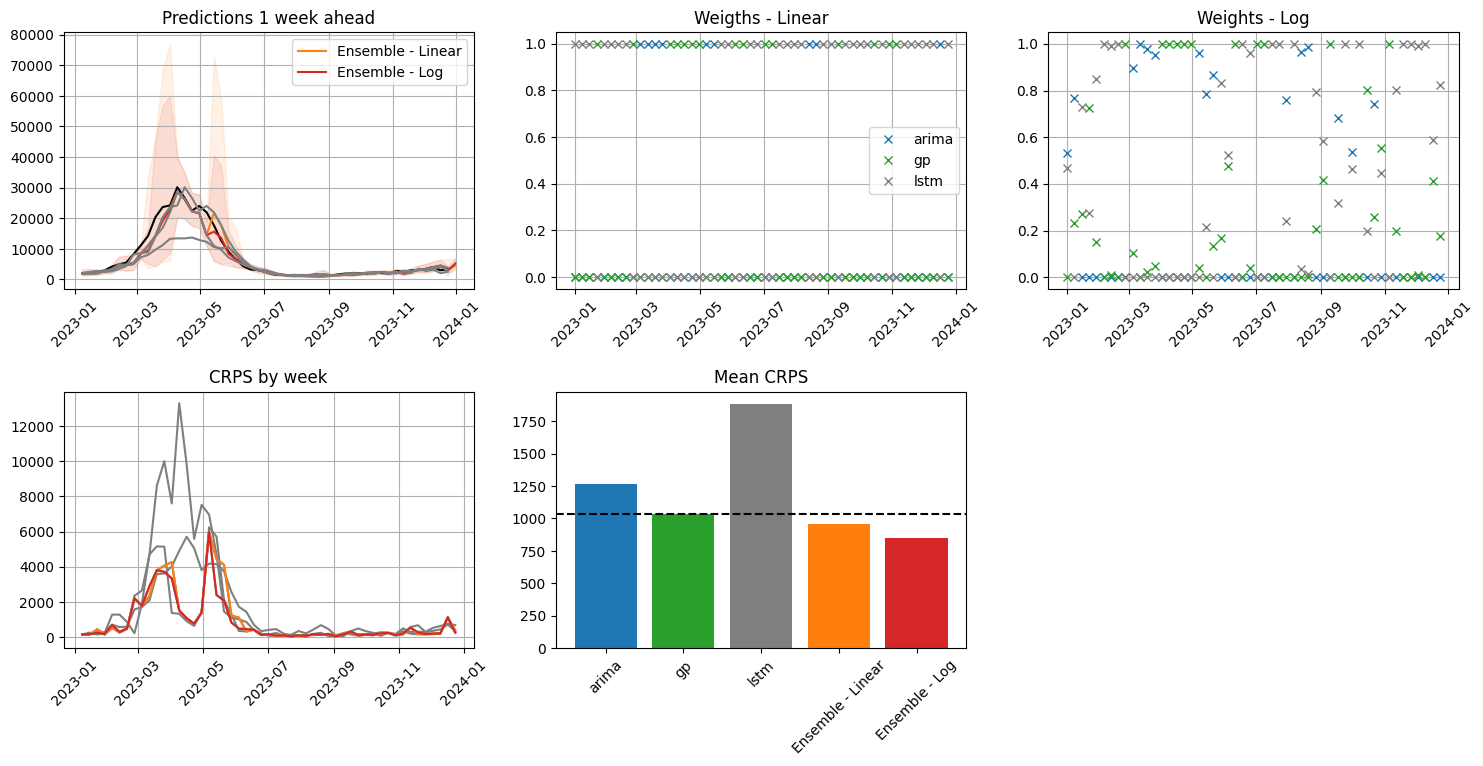

In [26]:
_,ax = plt.subplots(2, 3, figsize = (18,8))

ax[0,0].plot(df_casos_f.date, df_casos_f.casos, color = 'black')

for df, color, name in zip([df_ens_lin_, df_ens_log_], ['tab:orange', 'tab:red'],
                          ['Ensemble - Linear', 'Ensemble - Log']):

    ax[0,0].plot(df.date, df.pred, color = color, label = name)
    ax[0,0].fill_between(df.date, df.lower_95, df.upper_95, color=color, alpha = 0.1)

for model in ['arima', 'gp', 'lstm']: 
    df_pred_ = df_for_.loc[df_for_.model == model]
    ax[0,0].plot(df_pred_.date, df_pred_.pred, color = 'tab:gray')

ax[0,0].grid()
ax[0,0].legend()

ax[0,0].set_title(f'Predictions {step} week ahead')

ax[0,1].plot(df_w_lin.date, df_w_lin.weights_1, marker='x', linestyle='None', label = 'arima', color= 'tab:blue')
ax[0,1].plot(df_w_lin.date, df_w_lin.weights_2, marker='x', linestyle='None', label = 'gp',  color= 'tab:green')
ax[0,1].plot(df_w_lin.date, df_w_lin.weights_3, marker='x', linestyle='None', label = 'lstm',  color= 'tab:gray')

ax[0,2].plot(df_w_log.date, df_w_log.weights_1, marker='x', linestyle='None' , label = 'arima',  color= 'tab:blue')
ax[0,2].plot(df_w_log.date, df_w_log.weights_2, marker='x', linestyle='None', label = 'gp',  color= 'tab:green')
ax[0,2].plot(df_w_log.date, df_w_log.weights_3, marker='x', linestyle='None', label = 'lstm',  color= 'tab:gray')

ax[0,1].set_title('Weigths - Linear')
ax[0,2].set_title('Weights - Log')

ax[0,1].legend()
#ax[0,2].legend()
ax[0,1].grid()
ax[0,2].grid()

for col in df_scores.columns: 

    ax[1,0].plot(df_scores[col], color = 'tab:grey')

ax[1,0].plot(df_scores['CRPS_ensemble_linear'], color = 'tab:orange')
ax[1,0].plot(df_scores['CRPS_ensemble_log'], color = 'tab:red')

ax[1,0].grid()

ax[1,0].set_title('CRPS by week')

ax[1,1].bar(x = df_scores_mean.index, height = df_scores_mean.CRPS, color = ['tab:blue', 'tab:green', 'tab:grey', 
                                                                       'tab:orange', 'tab:red'])

ax[1,1].axhline(df_scores_mean.loc[['arima', 'gp', 'lstm']].min()[0], color = 'black', linestyle = '--')

#ax[1,1].set_xticklabels(df_scores_mean.index, rotation=45)

ax[1,1].set_title('Mean CRPS')

for ax_ in ax.ravel(): 
    for label in ax_.get_xticklabels():
        label.set_rotation(45)

ax[1, 2].axis('off')

plt.subplots_adjust(hspace = 0.4)
plt.show()